# Smoker Status Prediction using Bio-Signals

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

The original dataset can be found on kaggle.

https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals

In [4]:
df = pd.read_csv("data/train_dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

# Lets explore the data

In [5]:
print(f'The dataset shape {df.shape}')

The dataset shape (38984, 23)


In [6]:
df.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [7]:
df.describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,...,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000,38984.000000
mean,44.127591,164.689488,65.938718,82.062115,1.014955,1.008768,1.025369,1.026190,121.475631,75.994408,...,57.293146,115.081495,14.624264,1.086523,0.886030,26.198235,27.145188,39.905038,0.214421,0.367279
std,12.063564,9.187507,12.896581,9.326798,0.498527,0.493813,0.157246,0.159703,13.643521,9.658734,...,14.617822,42.883163,1.566528,0.402107,0.220621,19.175595,31.309945,49.693843,0.410426,0.482070
min,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,...,4.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,76.000000,0.800000,0.800000,1.000000,1.000000,112.000000,70.000000,...,47.000000,91.000000,13.600000,1.000000,0.800000,19.000000,15.000000,17.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,82.000000,1.000000,1.000000,1.000000,1.000000,120.000000,76.000000,...,55.000000,113.000000,14.800000,1.000000,0.900000,23.000000,21.000000,26.000000,0.000000,0.000000
75%,55.000000,170.000000,75.000000,88.000000,1.200000,1.200000,1.000000,1.000000,130.000000,82.000000,...,66.000000,136.000000,15.800000,1.000000,1.000000,29.000000,31.000000,44.000000,0.000000,1.000000
max,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,2.000000,2.000000,233.000000,146.000000,...,359.000000,1860.000000,21.100000,6.000000,11.600000,1090.000000,2914.000000,999.000000,1.000000,1.000000


In [8]:
df.isnull().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

No apparent missing data.

In [9]:
df.nunique()

age                     14
height(cm)              13
weight(kg)              22
waist(cm)              545
eyesight(left)          19
eyesight(right)         17
hearing(left)            2
hearing(right)           2
systolic               125
relaxation              94
fasting blood sugar    258
Cholesterol            279
triglyceride           389
HDL                    122
LDL                    286
hemoglobin             143
Urine protein            6
serum creatinine        34
AST                    195
ALT                    230
Gtp                    439
dental caries            2
smoking                  2
dtype: int64

Here is the breakdown of categorical and numerical variables

In [10]:
categorical = ['hearing(left)', 'hearing(right)', 'dental caries']
numerical = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
             'eyesight(right)', 'systolic', 'relaxation', 'fasting blood sugar', 
             'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 
             'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp']
target = ['smoking']

Number of non-smokers:  24666
Number of smokers:  14318


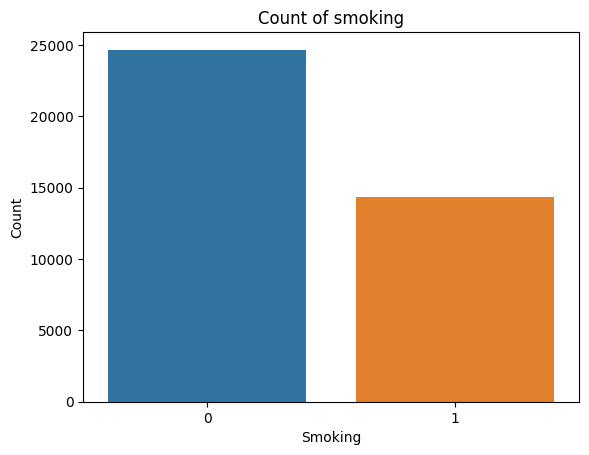

In [11]:
ax = sns.countplot(x='smoking', data=df)
ax.set_xticklabels(['0', '1'])
ax.set(xlabel='Smoking', ylabel='Count')
ax.set_title('Count of smoking')

no_smoking, smoker = df['smoking'].value_counts()
print('Number of non-smokers: ', no_smoking)
print('Number of smokers: ', smoker)

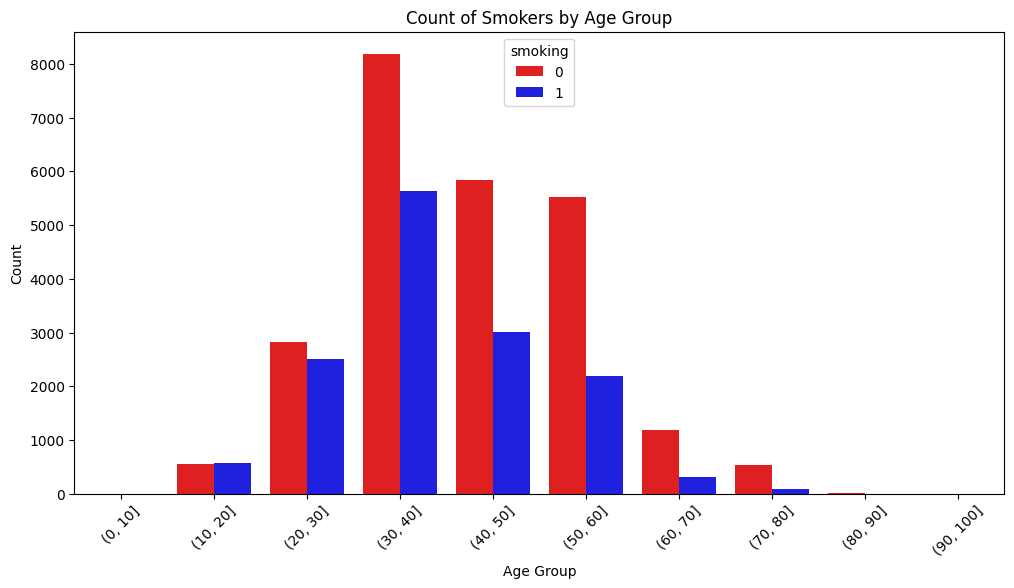

In [12]:
plt.figure(figsize=(12, 6))

age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ax = sns.countplot(x=pd.cut(df['age'], bins=age_bins), hue='smoking', data=df, palette={0: 'red', 1: 'blue'})
ax.set(xlabel='Age Group', ylabel='Count')
ax.set_title('Count of Smokers by Age Group')

plt.xticks(rotation=45)

plt.show()

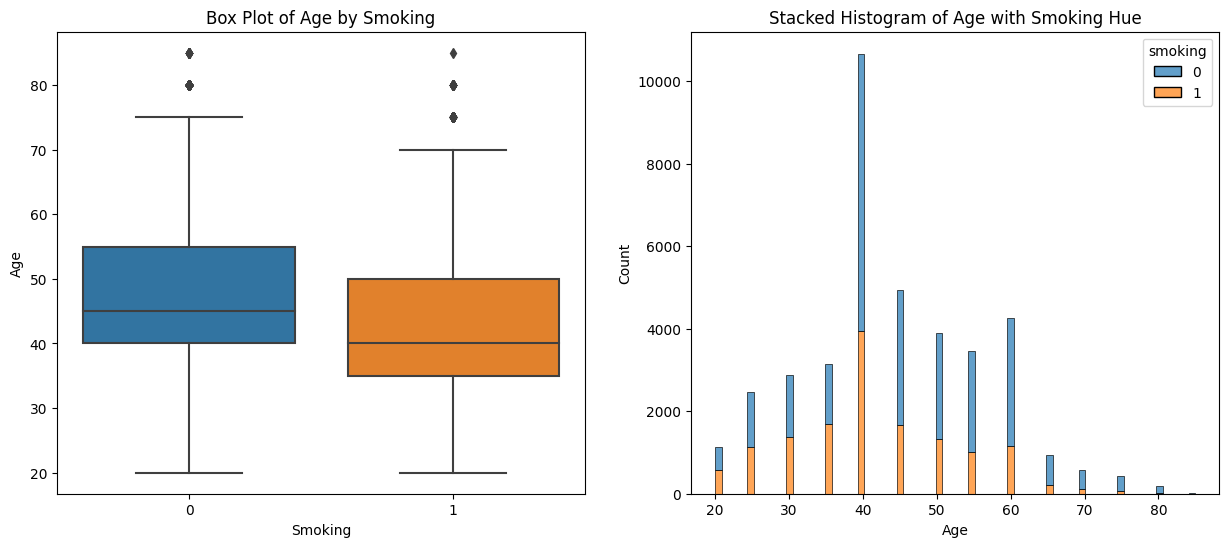

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(ax=axes[0], data=df, x='smoking', y='age')
axes[0].set(xlabel='Smoking', ylabel='Age')
axes[0].set_title('Box Plot of Age by Smoking')

sns.histplot(data=df, x='age', hue='smoking', ax=axes[1], multiple='stack', alpha=0.7)
axes[1].set(xlabel='Age', ylabel='Count')
axes[1].set_title('Stacked Histogram of Age with Smoking Hue')

plt.show()

Would appear increasing age there are more non smokers.

# Distributions

Lets look at the rest of the distributions

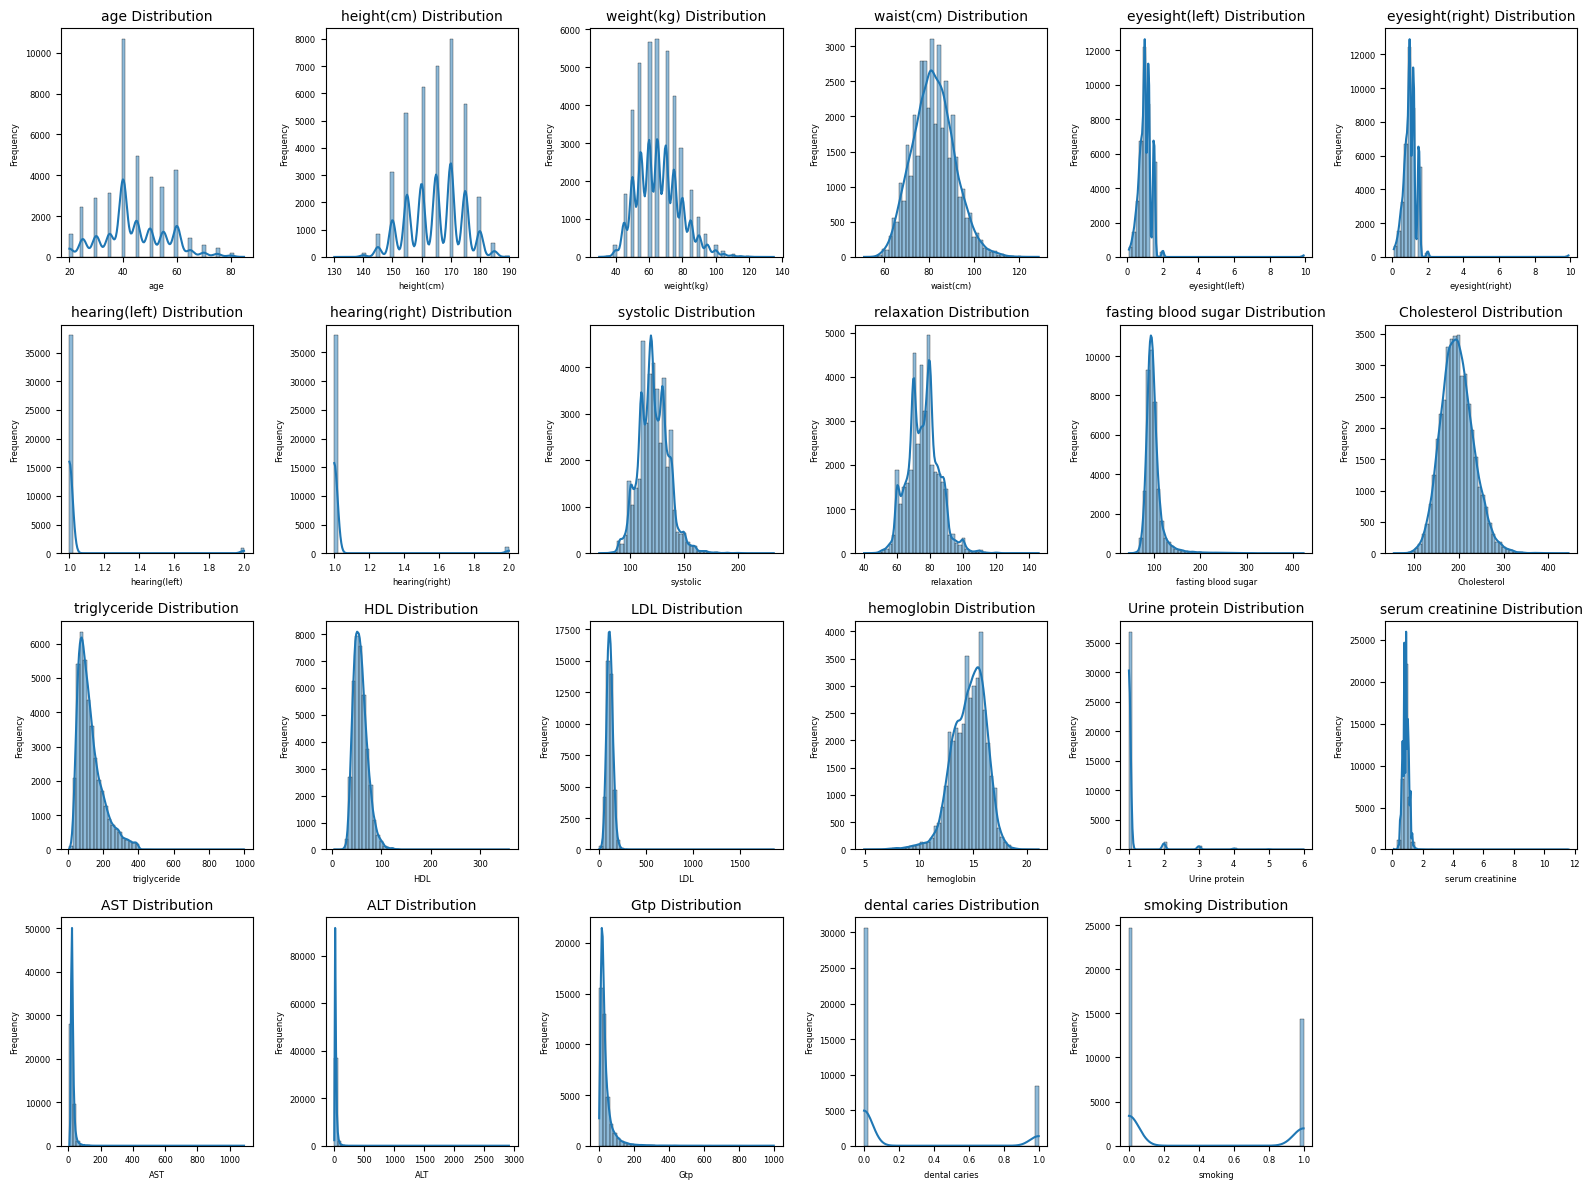

In [14]:
num_cols = df.shape[1]
num_rows = math.ceil(num_cols / 6)
fig, axes = plt.subplots(num_rows, 6, figsize=(16, 12))
axes = axes.ravel()

for i, column in enumerate(df.columns):
    sns.histplot(data=df, x=column, bins=50, ax=axes[i],  kde=True)
    axes[i].set_title(f'{column} Distribution', fontsize=10)
    axes[i].set_xlabel(column, fontsize=6)
    axes[i].set_ylabel('Frequency', fontsize=6)
    axes[i].tick_params(axis='both', which='both', labelsize=6)

for i in range(num_cols, num_rows * 6):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Outliers

In [15]:
df_num = df[numerical]

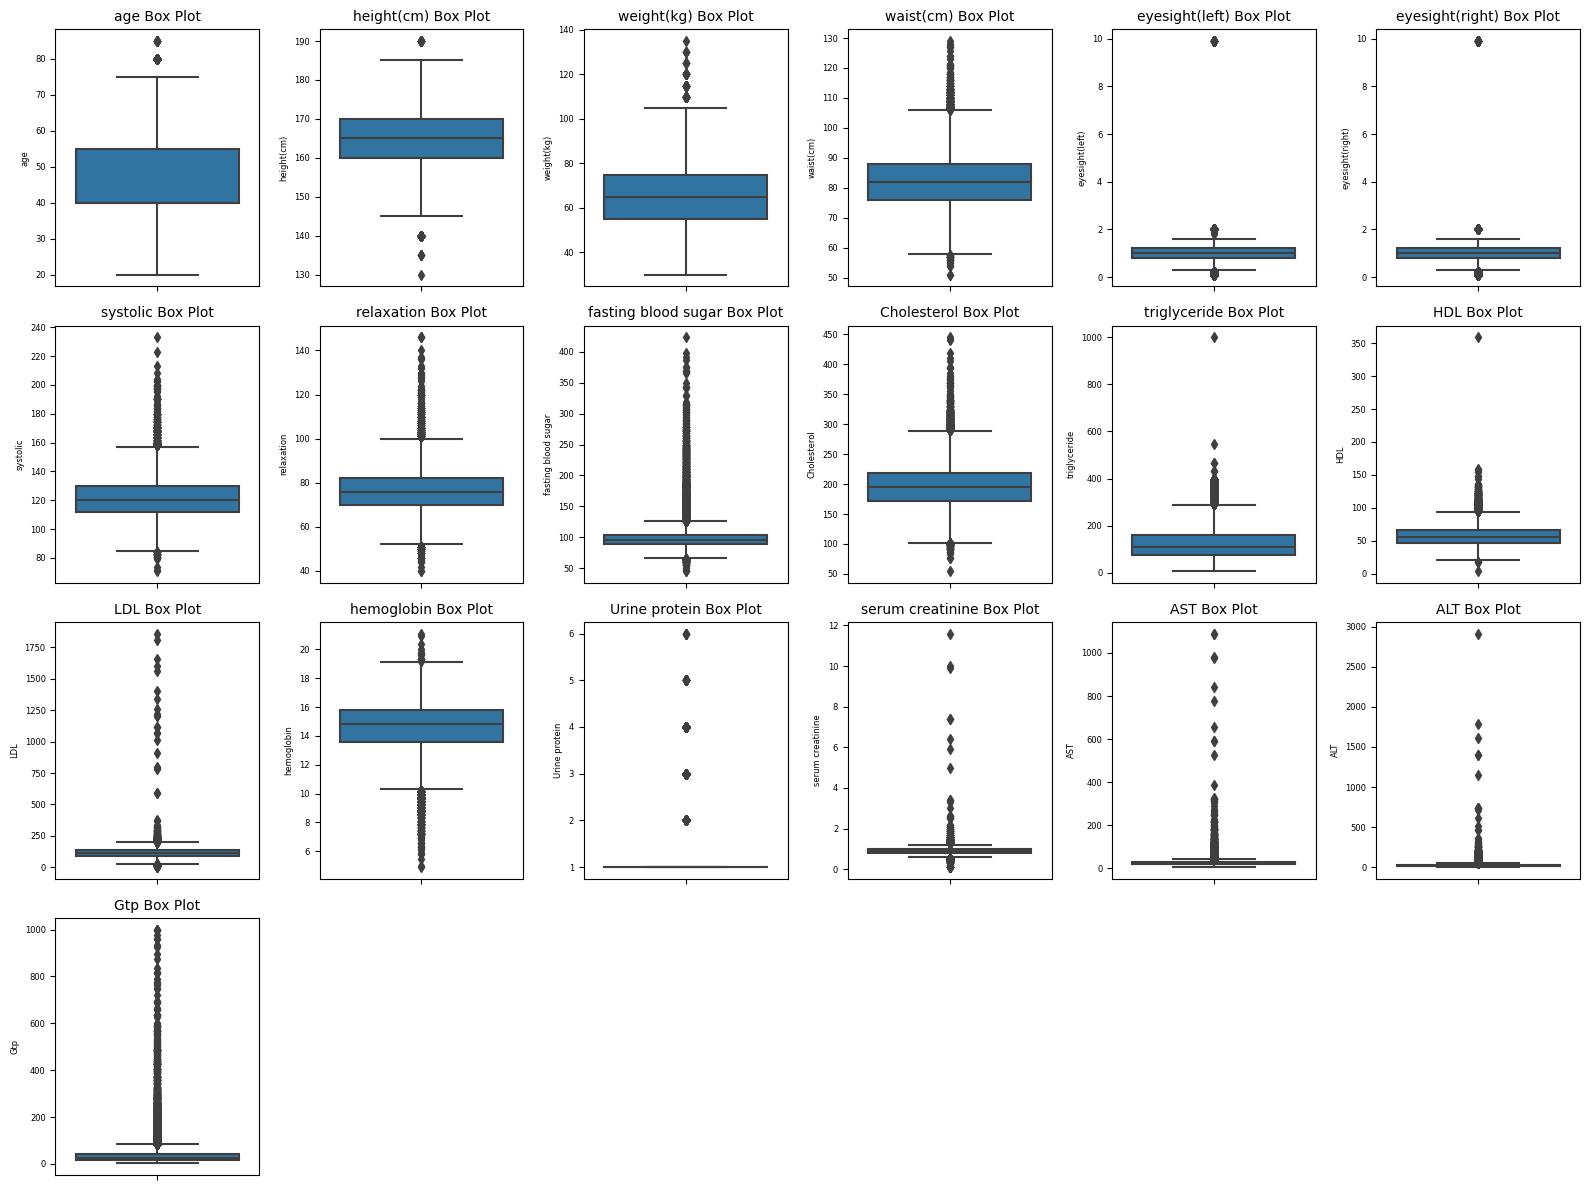

In [16]:
num_cols = df_num.shape[1]
num_rows = math.ceil(num_cols / 6)

fig, axes = plt.subplots(num_rows, 6, figsize=(16, 12))

axes = axes.ravel()

for i, column in enumerate(df_num.columns):
    sns.boxplot(data=df, y=column, ax=axes[i])
    axes[i].set_title(f'{column} Box Plot', fontsize=10)
    axes[i].set_ylabel(column, fontsize=6)
    axes[i].tick_params(axis='both', which='both', labelsize=6)

for i in range(num_cols, num_rows * 6):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [17]:
# Define a Z-Score threshold (e.g., ±3 is a common choice)
z_score_threshold = 3

# Identify outliers for all numeric columns

outliers = df_num[(np.abs((df_num - df_num.mean()) / df_num.std()) > z_score_threshold).any(axis=1)]

print(f'Numerical data {len(df_num)} Outliers {len(outliers)}')

print(f'Outlier percentage: {round((len(outliers)/len(df_num))*100, 4)}%')

print("Outliers:")
print(outliers)

Numerical data 38984 Outliers 4489
Outlier percentage: 11.515%
Outliers:
       age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0       35         170          85       97.0             0.9   
1       20         175         110      110.0             0.7   
2       45         155          65       86.0             0.9   
3       45         165          80       94.0             0.8   
16      50         170          75       84.0             1.0   
...    ...         ...         ...        ...             ...   
38925   40         165          60       77.0             0.9   
38938   65         165          55       88.6             9.9   
38961   40         150          55       87.0             0.8   
38976   40         165          60       85.0             0.7   
38981   40         170         105      124.0             0.6   

       eyesight(right)  systolic  relaxation  fasting blood sugar  \
0                  0.9       118          78                   97   
1       

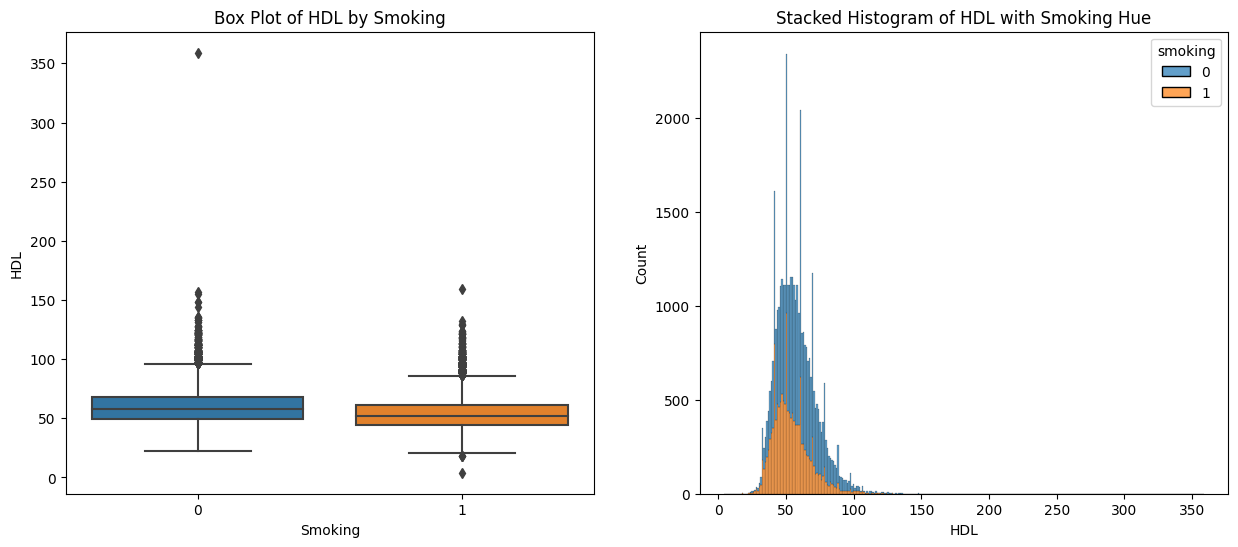

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(ax=axes[0], data=df, x='smoking', y='HDL')
axes[0].set(xlabel='Smoking', ylabel='HDL')
axes[0].set_title('Box Plot of HDL by Smoking')

sns.histplot(data=df, x='HDL', hue='smoking', ax=axes[1], multiple='stack', alpha=0.7)
axes[1].set(xlabel='HDL', ylabel='Count')
axes[1].set_title('Stacked Histogram of HDL with Smoking Hue')

plt.show()

NOTE: With increasing HDL more non smokers in the distribution.

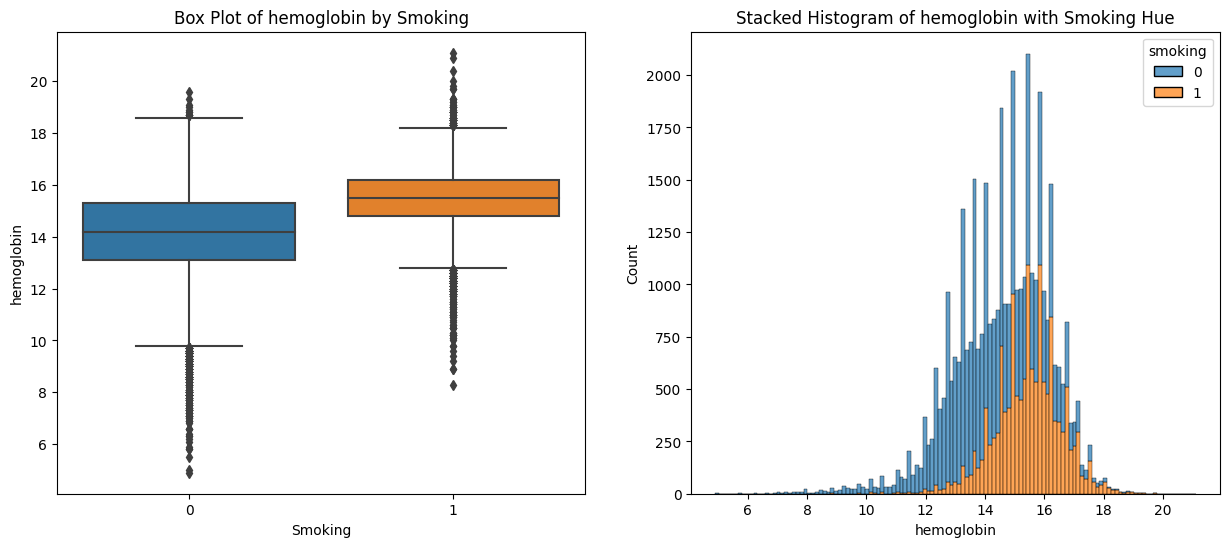

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(ax=axes[0], data=df, x='smoking', y='hemoglobin')
axes[0].set(xlabel='Smoking', ylabel='hemoglobin')
axes[0].set_title('Box Plot of hemoglobin by Smoking')

sns.histplot(data=df, x='hemoglobin', hue='smoking', ax=axes[1], multiple='stack', alpha=0.7)
axes[1].set(xlabel='hemoglobin', ylabel='Count')
axes[1].set_title('Stacked Histogram of hemoglobin with Smoking Hue')

plt.show()

NOTE: Increasing hemoglobin shows more smokers in the distribution

In [20]:
df_num.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'systolic', 'relaxation', 'fasting blood sugar',
       'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin',
       'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp'],
      dtype='object')

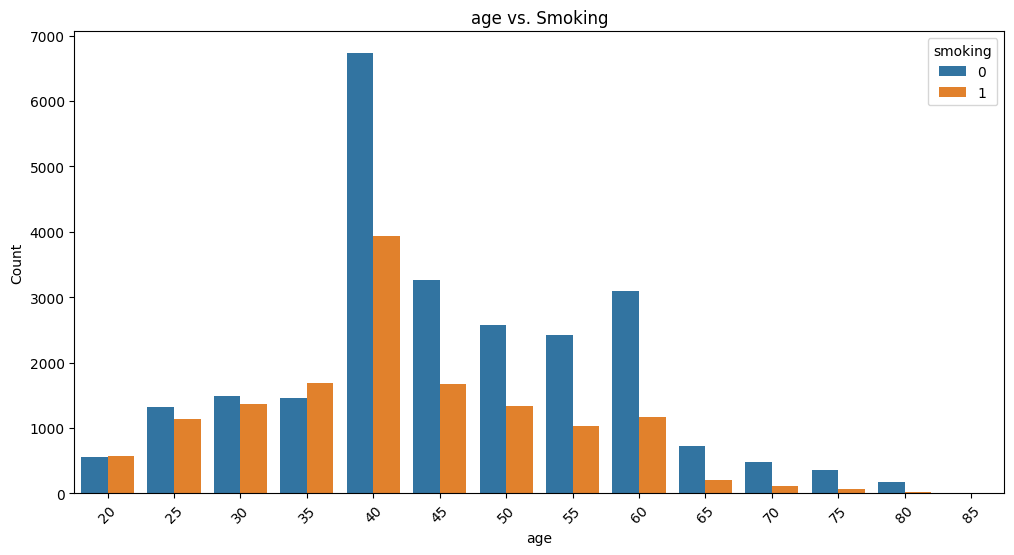

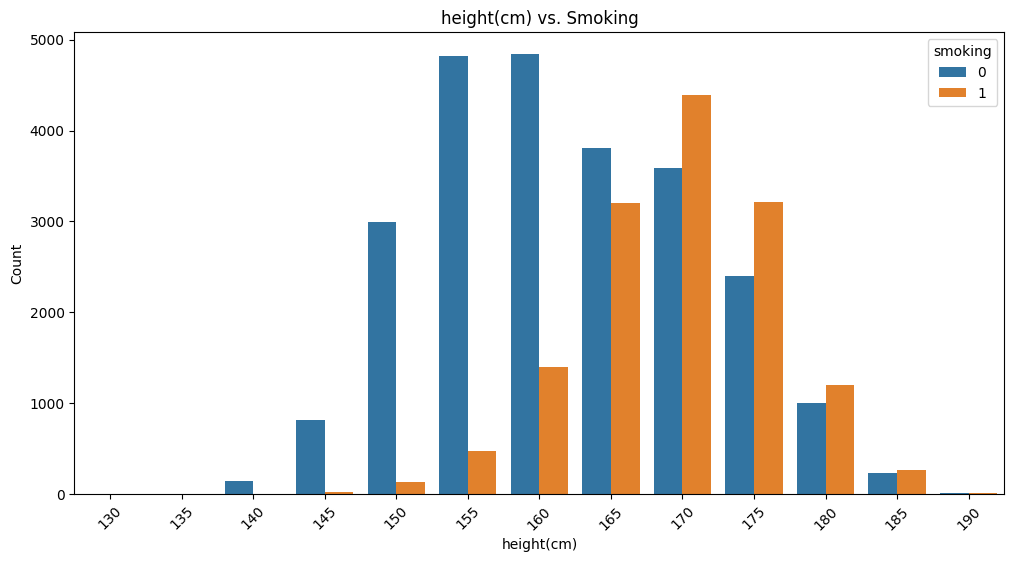

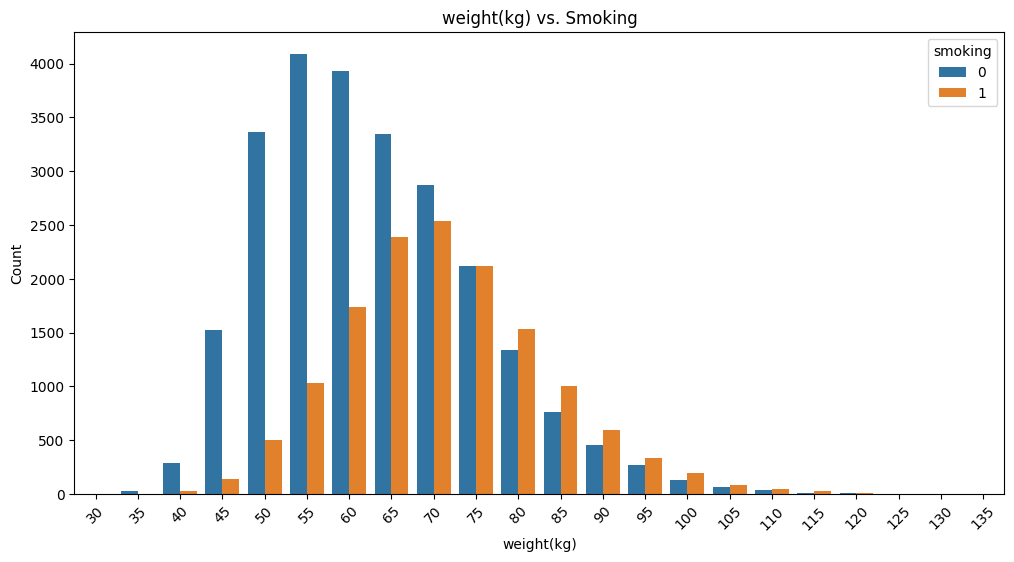

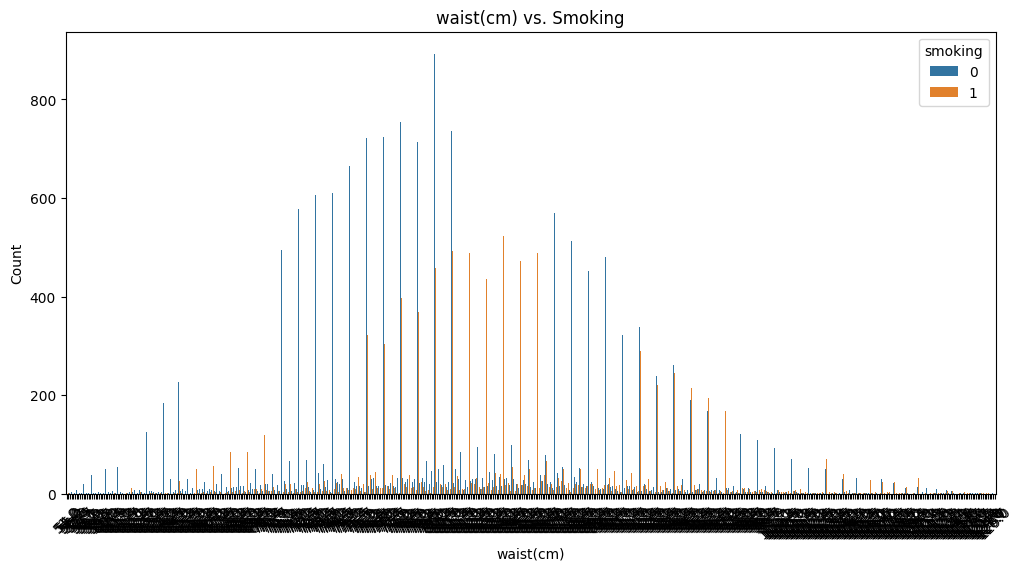

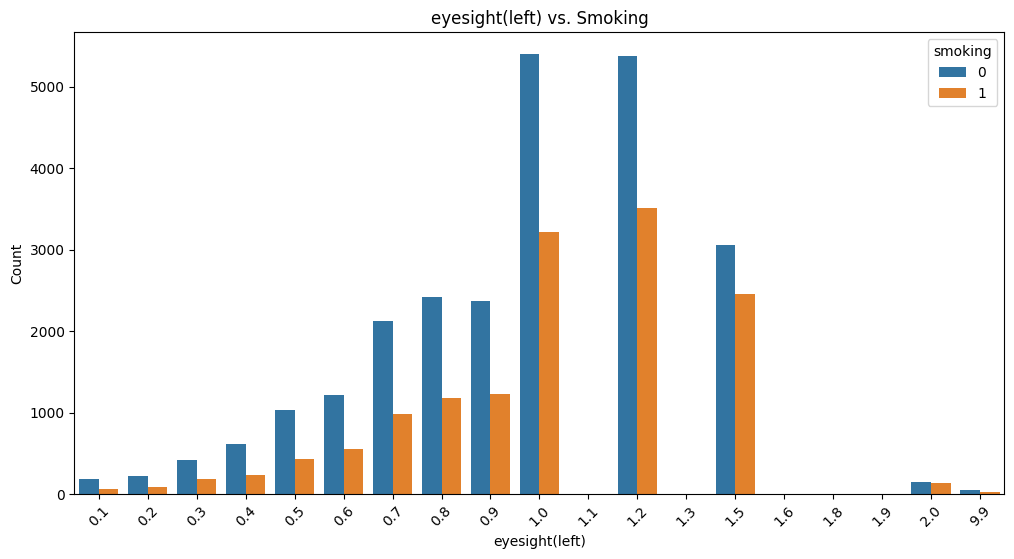

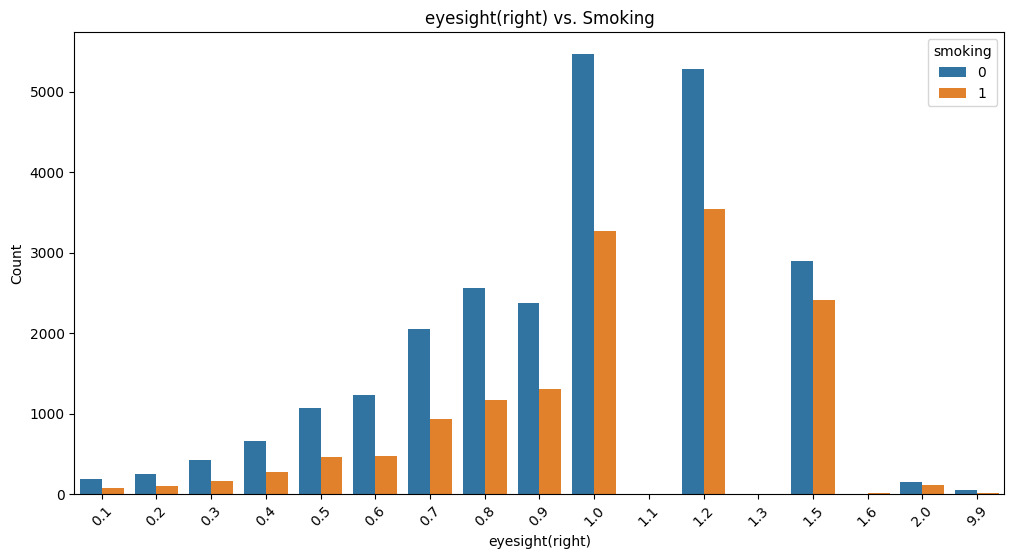

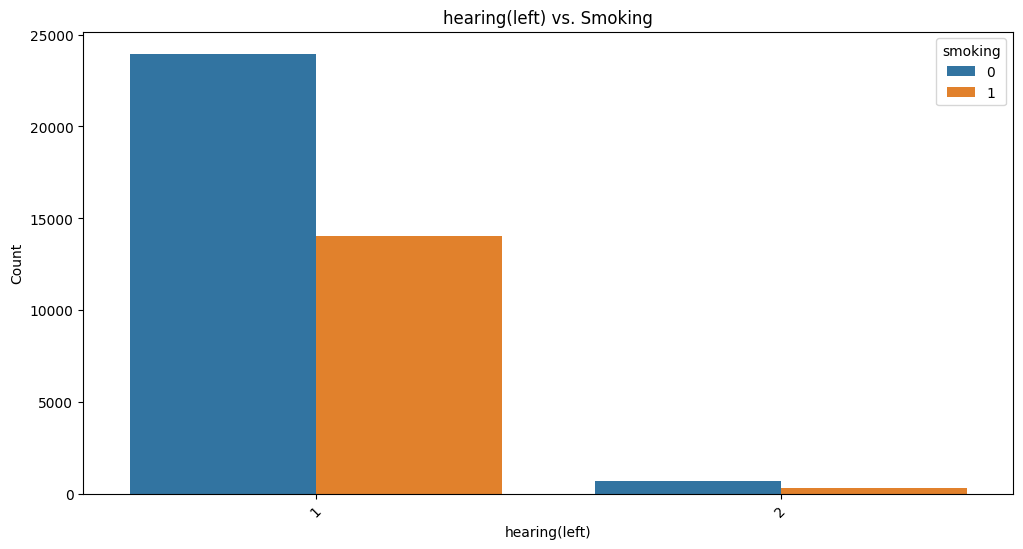

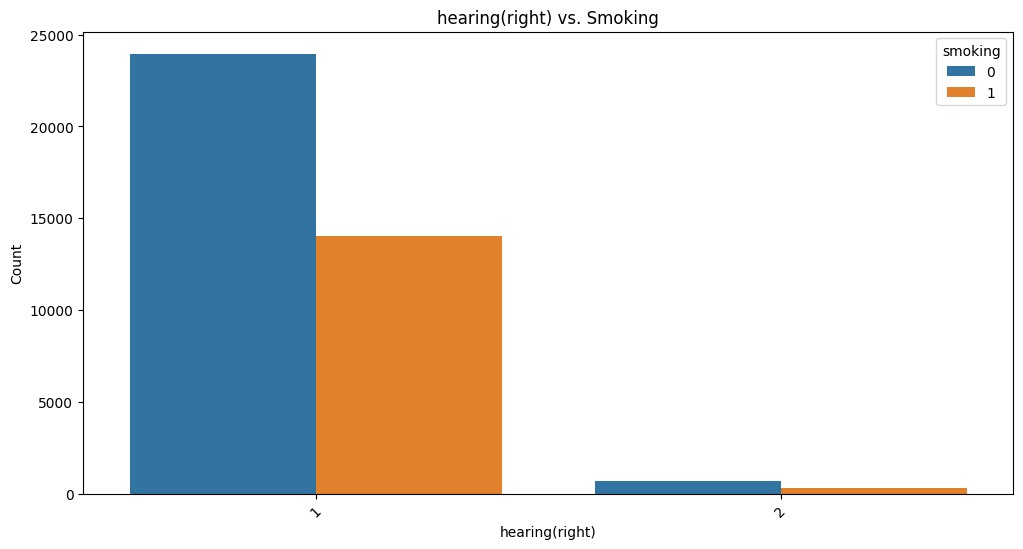

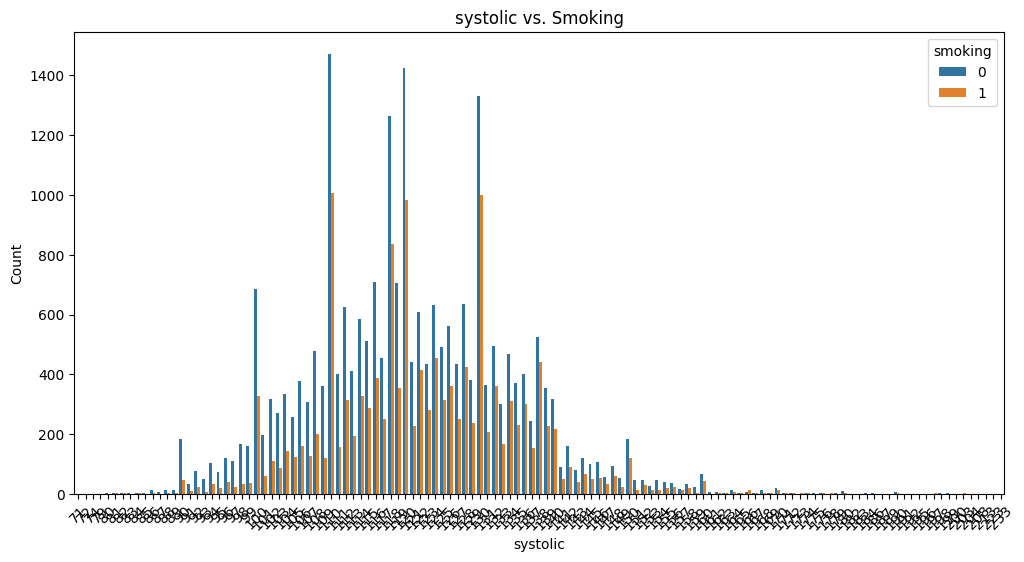

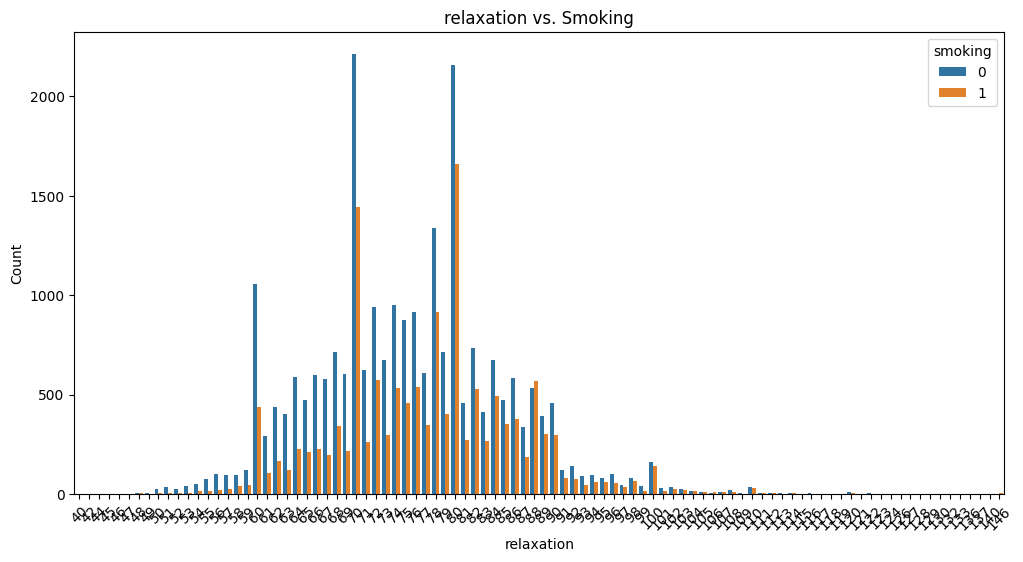

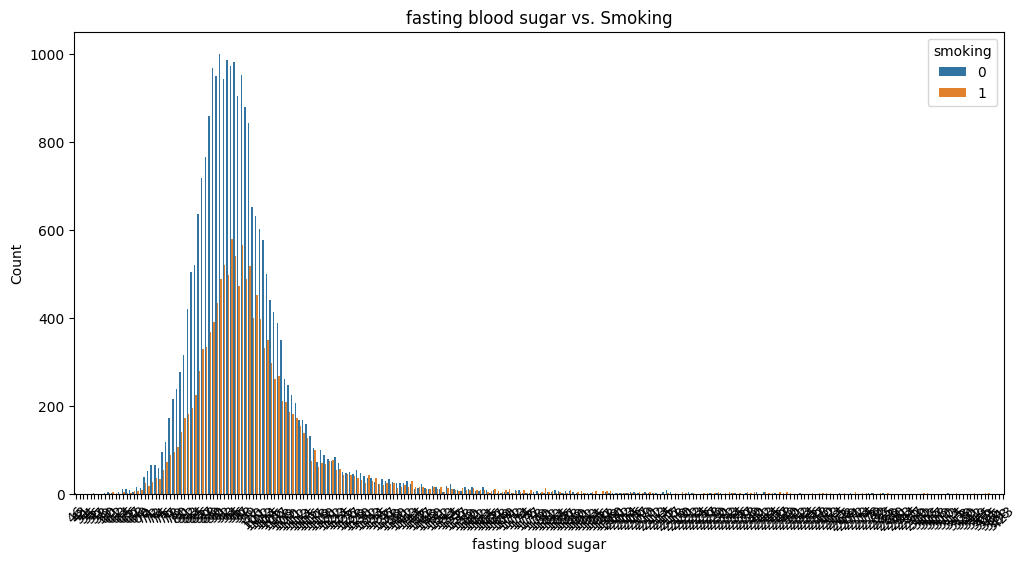

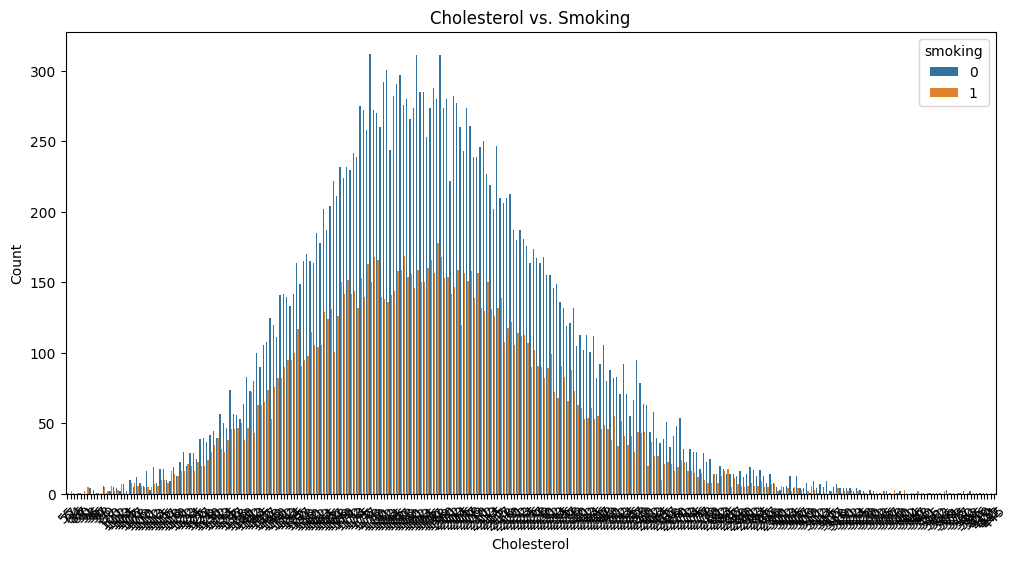

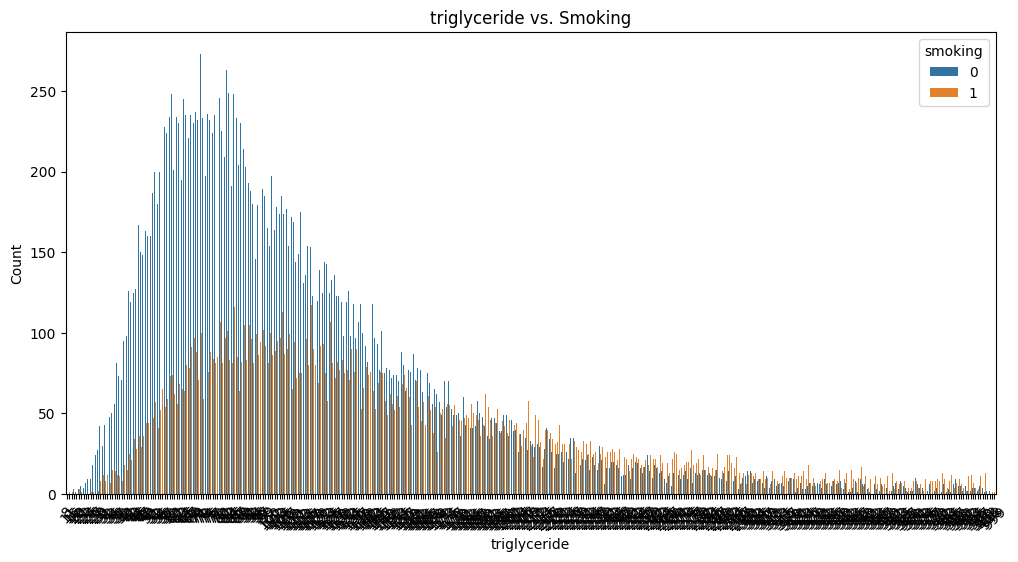

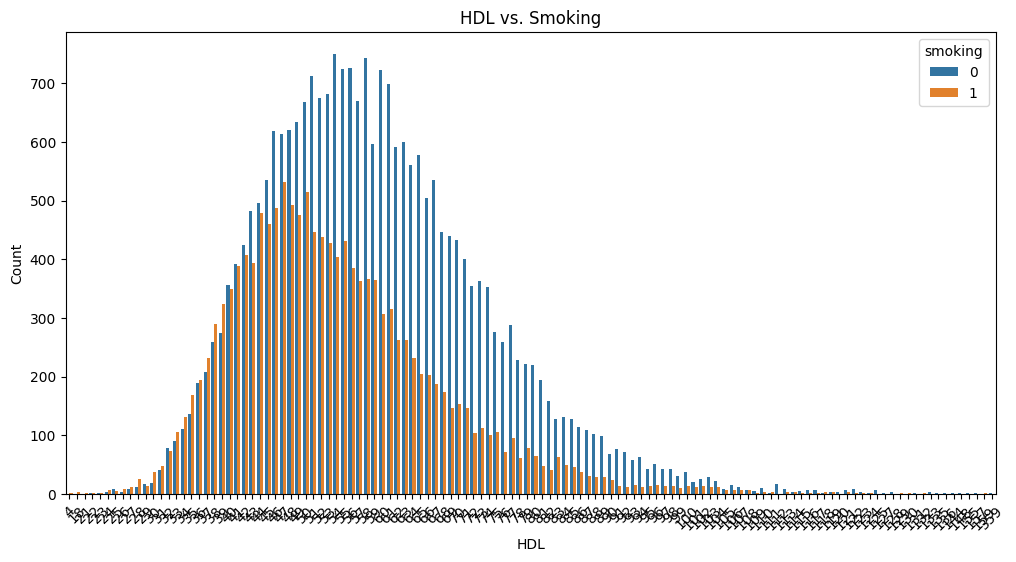

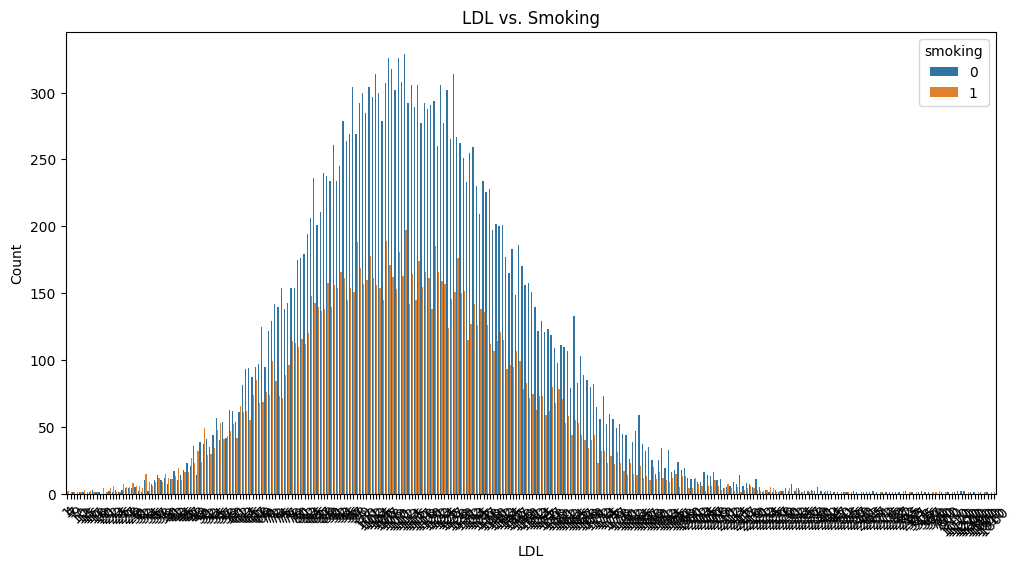

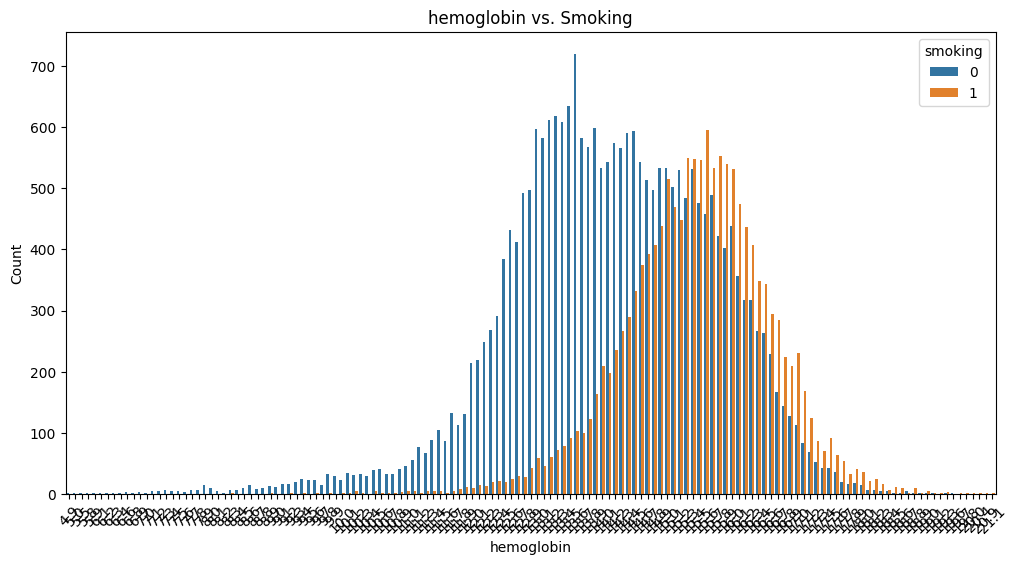

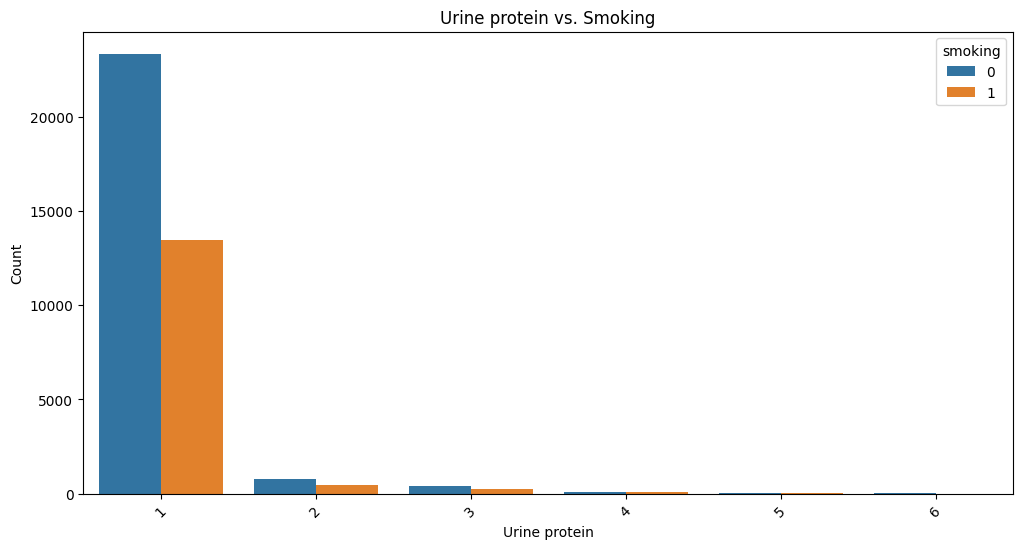

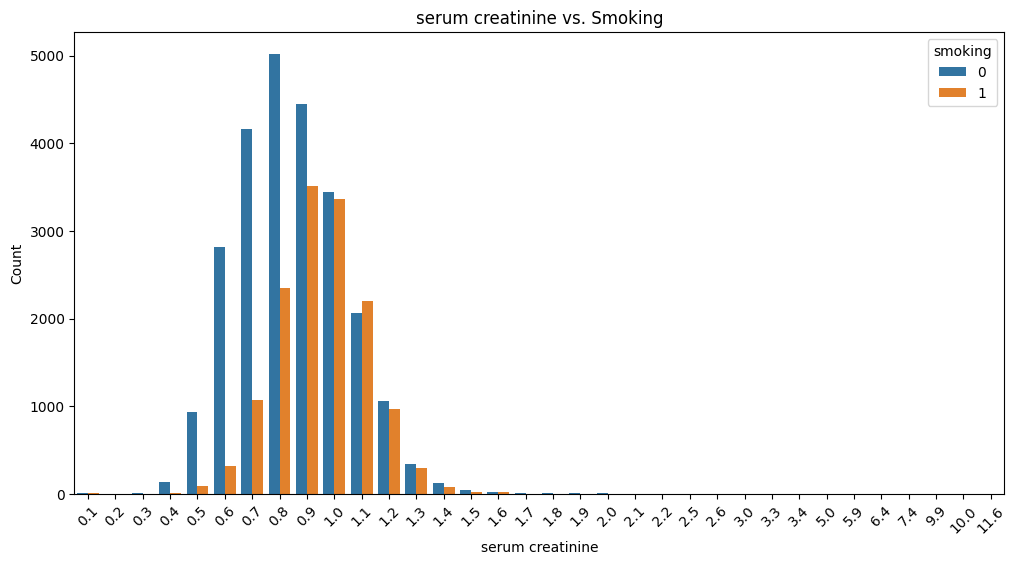

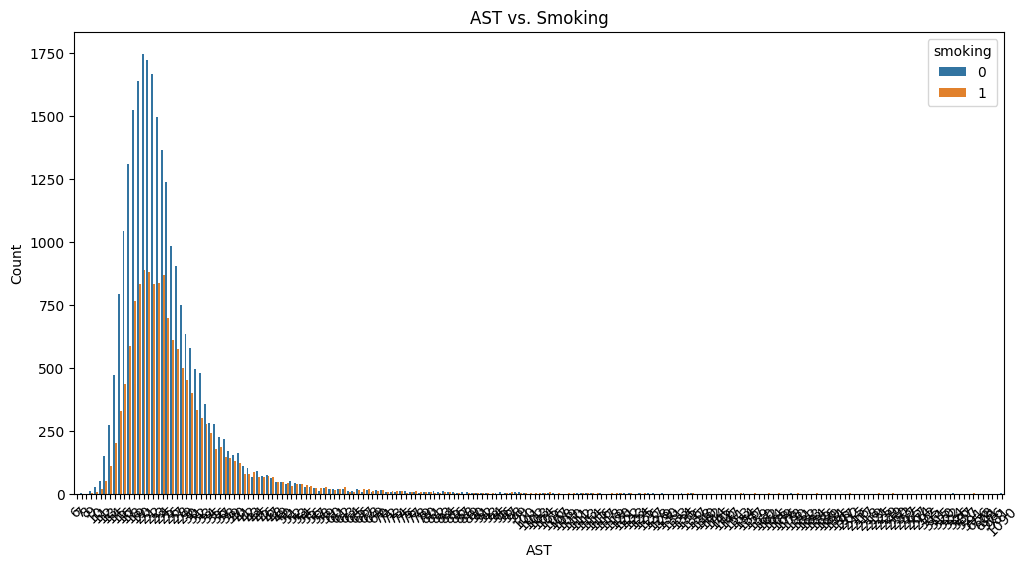

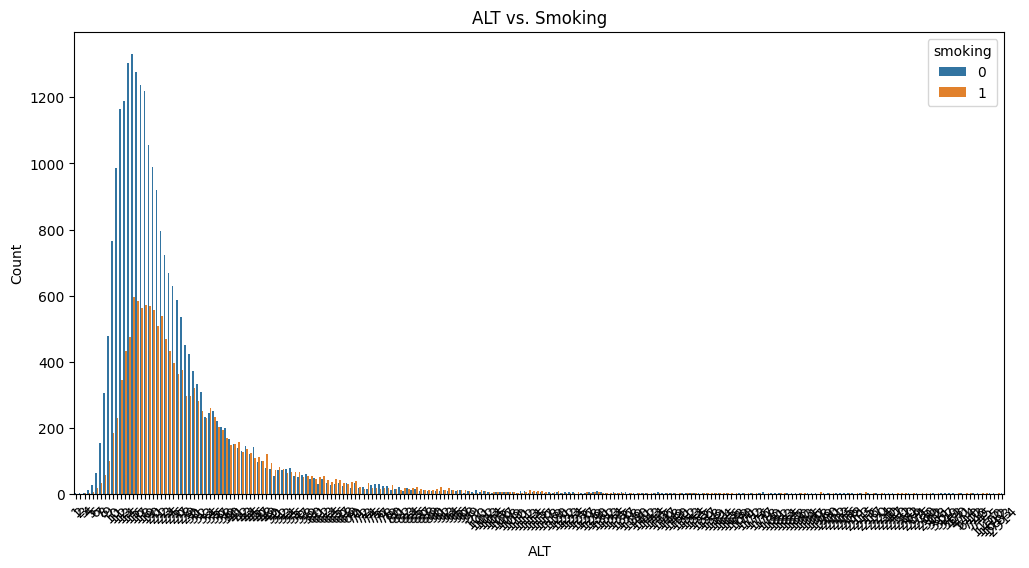

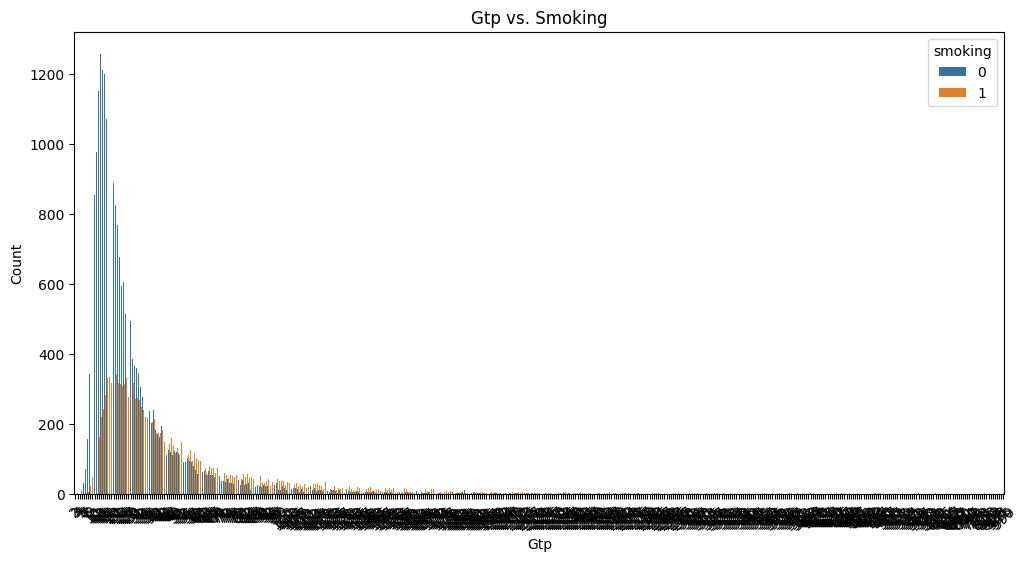

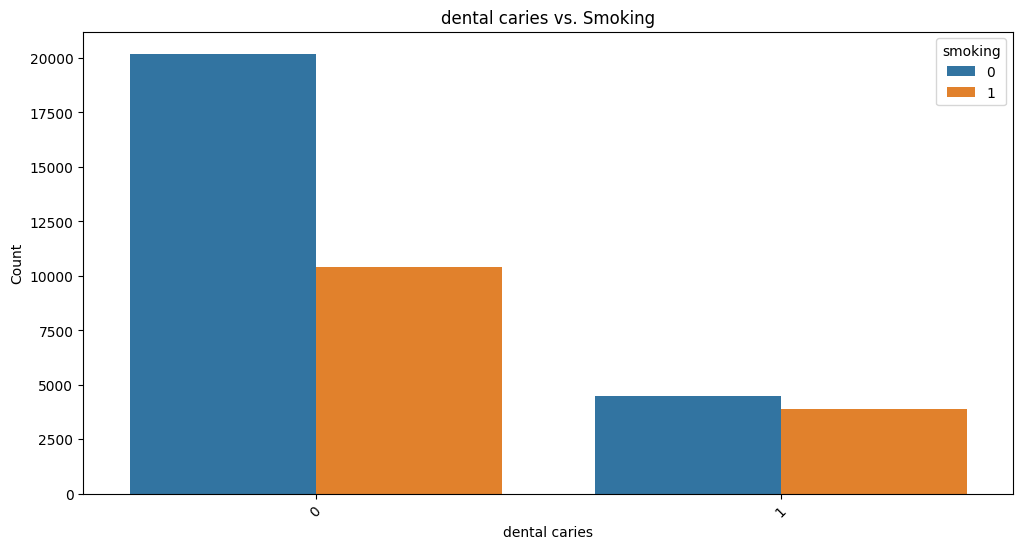

In [21]:
for feature in df.drop(columns=['smoking']).columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=feature, hue='smoking')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'{feature} vs. Smoking')
    plt.xticks(rotation=45)
    plt.show()

Studying the relationship between smoking we appear to have noteable correlation with height, weight, triglyceride, HDL, hemoglobin and serum creatine

# Correlation Matrix

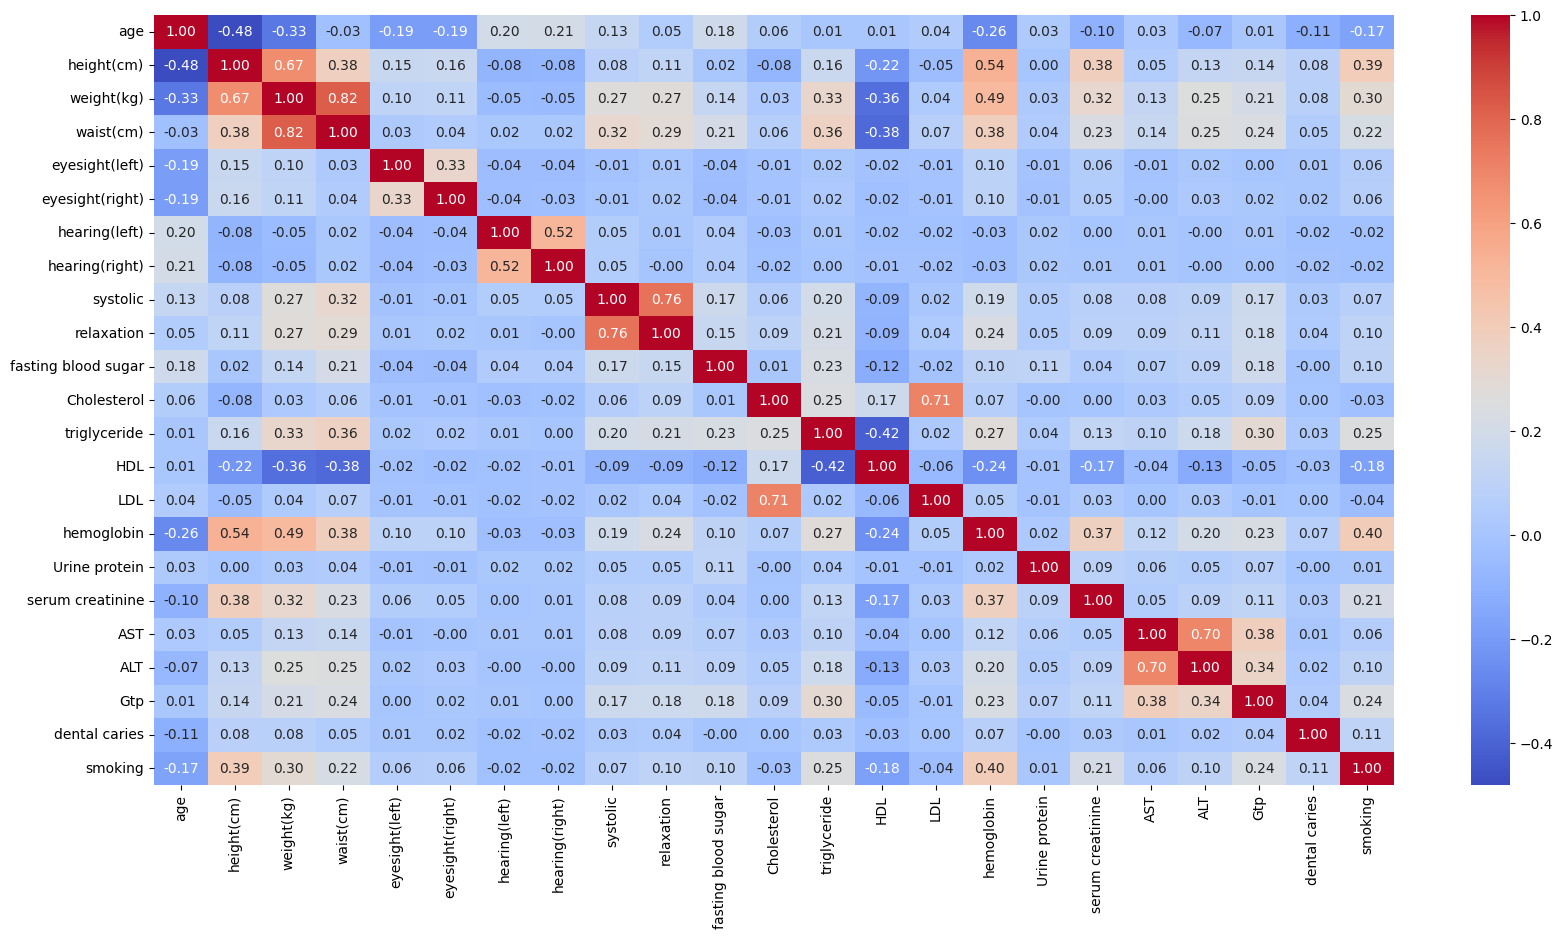

In [22]:
# Create a correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 10))

# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Show the plot
plt.show()

Observations correlations waist and weight, relaxation and systolic, LDL and cholesterol, triglyceride and HDL, ALT and AST

Smoking has positive correlation with hemoglobin, height, weight, triglyceride, waist, serum creatine

and negative correlation with age and HDL

# Feature Engineering

Considering taking a HDL/LDL ratio and a weight waist ratio.

In [23]:
df.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [24]:
df_train = df.copy()

In [25]:
numerical_feateng = numerical[:]

In [26]:
df_train['Log_HDL_LDL_Ratio'] = np.log1p(df_train['HDL'] / df_train['LDL'])  

In [27]:
df_train['Log_HDL_LDL_Ratio'].describe()

count    38984.000000
mean         0.430124
std          0.158449
min          0.019152
25%          0.322288
50%          0.398950
75%          0.503104
max          3.850148
Name: Log_HDL_LDL_Ratio, dtype: float64

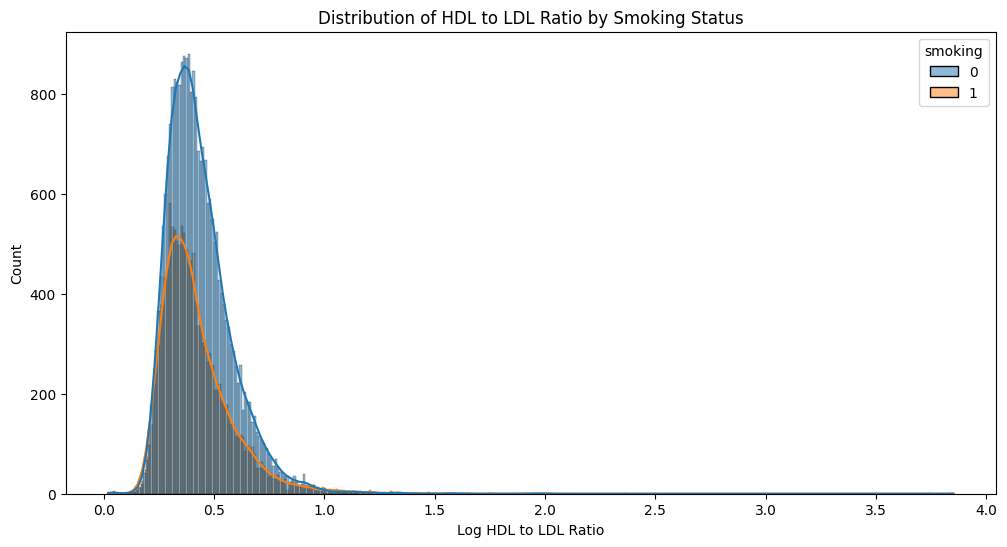

In [28]:
ratio_summary = df_train.groupby('smoking')['Log_HDL_LDL_Ratio'].describe()
plt.figure(figsize=(12, 6))
sns.histplot(data=df_train, x='Log_HDL_LDL_Ratio', hue='smoking', kde=True)
plt.xlabel('Log HDL to LDL Ratio')
plt.ylabel('Count')
plt.title('Distribution of HDL to LDL Ratio by Smoking Status')
plt.show()

In [29]:
numerical_feateng.append('Log_HDL_LDL_Ratio')

Attempted some other feature engineering but didn't see model improvements

In [30]:
# df_train['Log_HDL_TRIG_Ratio'] = np.log1p(df_train['HDL'] / df_train['triglyceride'])

# df_train['Age_HDL_Interaction'] = np.log1p(df_train['age'] * df_train['HDL'])  
# ratio_summary = df_train.groupby('smoking')['Age_HDL_Interaction'].describe()
# plt.figure(figsize=(12, 6))
# sns.histplot(data=df_train, x='Age_HDL_Interaction', hue='smoking', kde=True)
# plt.xlabel('Age_HDL_Interaction')
# plt.ylabel('Count')
# plt.title('Distribution of AGE and HDL interaction by Smoking Status')
# plt.show()

In [31]:
# numerical_feateng.append('Age_HDL_Interaction')

In [32]:
# df_train['Log_AST_ALT_Ratio'] = np.log1p(df_train['AST'] / df_train['ALT'])  
# ratio_summary = df_train.groupby('smoking')['Log_AST_ALT_Ratio'].describe()
# plt.figure(figsize=(12, 6))
# sns.histplot(data=df_train, x='Log_AST_ALT_Ratio', hue='smoking', kde=True)
# plt.xlabel('Log AST to ALT Ratio')
# plt.ylabel('Count')
# plt.title('Distribution of AST to ALT Ratio by Smoking Status')
# plt.show()

In [33]:
# numerical_feateng.append('Log_AST_ALT_Ratio')

In [34]:
# df_train['Log_HDL_Cholesterol_Ratio'] = np.log1p(df_train['HDL'] / df_train['Cholesterol'])  
# ratio_summary = df_train.groupby('smoking')['Log_HDL_Cholesterol_Ratio'].describe()
# plt.figure(figsize=(12, 6))
# sns.histplot(data=df_train, x='Log_HDL_Cholesterol_Ratio', hue='smoking', kde=True)
# plt.xlabel('Log HDL to Cholesterol Ratio')
# plt.ylabel('Count')
# plt.title('Distribution of HDL to Cholesterol Ratio by Smoking Status')
# plt.show()

In [35]:
# numerical_feateng.append('Log_HDL_Cholesterol_Ratio')

In [36]:
# df_train['Log_height_waist_Ratio'] = np.log1p(df_train['height(cm)'] / df_train['waist(cm)'])  
# ratio_summary = df_train.groupby('smoking')['Log_height_waist_Ratio'].describe()
# plt.figure(figsize=(12, 6))
# sns.histplot(data=df_train, x='Log_height_waist_Ratio', hue='smoking', kde=True)
# plt.xlabel('Log height to waist Ratio')
# plt.ylabel('Count')
# plt.title('Distribution of height to waist Ratio by Smoking Status')
# plt.show()

In [37]:
# numerical_features.append('Log_height_waist_Ratio')

In [38]:
# df_train['Log_weight_waist_Ratio'] = np.log1p(df_train['weight(kg)'] / df_train['waist(cm)'])  
# ratio_summary = df_train.groupby('smoking')['Log_weight_waist_Ratio'].describe()
# plt.figure(figsize=(12, 6))
# sns.histplot(data=df_train, x='Log_weight_waist_Ratio', hue='smoking', kde=True)
# plt.xlabel('Log weight to waist Ratio')
# plt.ylabel('Count')
# plt.title('Distribution of weight to waist Ratio by Smoking Status')
# plt.show()

In [39]:
# numerical_feateng.append('Log_weight_waist_Ratio')

In [40]:
# tried a health index but couldn't find a good combination
# weights = [0.20, 0.20, -0.20, 0.20, 0.40,]

# scaler = StandardScaler()
# # normalized_features = scaler.fit_transform(df_train[['age', 'height(cm)', 'weight(kg)', 'HDL', 'triglyceride', 'hemoglobin']])
# normalized_features = scaler.fit_transform(df_train[['height(cm)', 'weight(kg)', 'HDL', 'triglyceride', 'hemoglobin']])

# health_index = (normalized_features * weights).sum(axis=1)

# df_train['Health_Index'] = health_index

# summary = df_train.groupby('smoking')['Health_Index'].describe()
# plt.figure(figsize=(12, 6))
# sns.histplot(data=df_train, x='Health_Index', hue='smoking', kde=True)
# plt.xlabel('Health_Index')
# plt.ylabel('Count')
# plt.title('Distribution of Health_Index by Smoking Status')
# plt.show()

# numerical_feateng.append('Health_Index')

In [41]:
numerical_feateng

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'systolic',
 'relaxation',
 'fasting blood sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'Urine protein',
 'serum creatinine',
 'AST',
 'ALT',
 'Gtp',
 'Log_HDL_LDL_Ratio']

# Baseline Models

## Logistic regression

In [42]:
def train_logistic_regression(X, y, numerical_features, categorical_features):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define preprocessing steps for numerical and categorical features
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder())
    ])

    # Use ColumnTransformer to apply the appropriate transformations to each feature type
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create the preprocessing and modeling pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=2000))
    ])

    # Fit the model to the data
    model.fit(X_train, y_train)

    # Make predictions
    train_preds = model.predict_proba(X_train)[:, 1]
    train_score = roc_auc_score(y_train, train_preds)
    print(f'ROC training score: {round(train_score, 2)}')

    val_preds = model.predict_proba(X_val)[:, 1]

    # Evaluate the model
    val_score = roc_auc_score(y_val, val_preds)
    print(f'ROC validation score: {round(val_score, 4)}')

    return model

In [43]:
def train_decision_tree(X, y, numerical_features, categorical_features):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define preprocessing steps for numerical and categorical features
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder())
    ])

    # Use ColumnTransformer to apply the appropriate transformations to each feature type
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create the preprocessing and modeling pipeline for the decision tree classifier
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])

    # Fit the model to the data
    model.fit(X_train, y_train)

    # Make predictions
    train_preds = model.predict_proba(X_train)[:, 1]
    train_score = roc_auc_score(y_train, train_preds)
    print(f'ROC training score: {round(train_score, 2)}')

    val_preds = model.predict_proba(X_val)[:, 1]

    # Evaluate the model
    val_score = roc_auc_score(y_val, val_preds)
    print(f'ROC validation score: {round(val_score, 4)}')

    return model

In [44]:
def train_random_forest(X, y, numerical_features, categorical_features):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define preprocessing steps for numerical and categorical features
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder())
    ])

    # Use ColumnTransformer to apply the appropriate transformations to each feature type
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create the preprocessing and modeling pipeline for the random forest classifier
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_jobs=-1, random_state=42))
    ])

    # Fit the model to the data
    model.fit(X_train, y_train)

    # Make predictions
    train_preds = model.predict_proba(X_train)[:, 1]
    train_score = roc_auc_score(y_train, train_preds)
    print(f'ROC training score: {round(train_score, 2)}')

    val_preds = model.predict_proba(X_val)[:, 1]

    # Evaluate the model
    val_score = roc_auc_score(y_val, val_preds)
    print(f'ROC validation score: {round(val_score, 4)}')

    return model

In [45]:
def train_xgboost_classifier(X, y, numerical_features, categorical_features):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define preprocessing steps for numerical and categorical features
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder())
    ])

    # Use ColumnTransformer to apply the appropriate transformations to each feature type
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create the preprocessing and modeling pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(n_jobs=-1))  # XGBoost classifier
    ])

    # Fit the model to the data
    model.fit(X_train, y_train)

    feature_importances = model.named_steps['classifier'].feature_importances_

    # Print feature importances
    for importance, feature in sorted(zip(feature_importances, X_train.columns), reverse=True):
        print(f'Feature: {feature}, Importance: {importance:.4f}')

    # Make predictions
    train_preds = model.predict_proba(X_train)[:, 1]
    train_score = roc_auc_score(y_train, train_preds)
    print(f'ROC training score: {round(train_score, 2)}')

    val_preds = model.predict_proba(X_val)[:, 1]

    # Evaluate the model
    val_score = roc_auc_score(y_val, val_preds)
    print(f'ROC validation score: {round(val_score, 4)}')

    return model

# Trained Baseline Models

In [46]:
# checking baseline
X = df.drop(columns=['smoking'])
y = df[target].values.ravel()

In [47]:
# Logistic Regression Baseline
lr_model = train_logistic_regression(X, y, numerical, categorical)

ROC training score: 0.81
ROC validation score: 0.8074


In [48]:
# Decision Tree Baseline
dt_model = train_decision_tree(X, y, numerical, categorical)

ROC training score: 1.0
ROC validation score: 0.7253


In [49]:
# Random Forest Tree Baseline
rf_model = train_random_forest(X, y, numerical, categorical)

ROC training score: 1.0
ROC validation score: 0.8868


In [50]:
# XGboost Baseline
xgb_model = train_xgboost_classifier(X, y, numerical, categorical)

Feature: height(cm), Importance: 0.3807
Feature: HDL, Importance: 0.0859
Feature: AST, Importance: 0.0680
Feature: age, Importance: 0.0362
Feature: hemoglobin, Importance: 0.0311
Feature: serum creatinine, Importance: 0.0277
Feature: fasting blood sugar, Importance: 0.0261
Feature: triglyceride, Importance: 0.0245
Feature: Cholesterol, Importance: 0.0242
Feature: weight(kg), Importance: 0.0230
Feature: hearing(left), Importance: 0.0225
Feature: Urine protein, Importance: 0.0225
Feature: waist(cm), Importance: 0.0223
Feature: dental caries, Importance: 0.0223
Feature: hearing(right), Importance: 0.0214
Feature: systolic, Importance: 0.0213
Feature: eyesight(right), Importance: 0.0206
Feature: relaxation, Importance: 0.0204
Feature: ALT, Importance: 0.0194
Feature: LDL, Importance: 0.0185
Feature: eyesight(left), Importance: 0.0175
Feature: Gtp, Importance: 0.0000
ROC training score: 0.95
ROC validation score: 0.8479


Out of the baseline models the random forest tree is the best with a roc of ROC validation score: 0.8868

# With feature engineering

In [51]:
X = df_train.drop(columns=['smoking'])
y = df_train[target].values.ravel() 

In [52]:
# Now with experimenting
lr_model = train_logistic_regression(X, y, numerical_feateng, categorical)

ROC training score: 0.81
ROC validation score: 0.8078


In [53]:
# Random Forest Tree
rf_model = train_random_forest(X, y, numerical_feateng, categorical)

ROC training score: 1.0
ROC validation score: 0.8877


In [54]:
# XGBoost
xgb_model = train_xgboost_classifier(X, y, numerical_feateng, categorical)

Feature: height(cm), Importance: 0.3419
Feature: HDL, Importance: 0.0849
Feature: AST, Importance: 0.0739
Feature: age, Importance: 0.0362
Feature: hemoglobin, Importance: 0.0313
Feature: Log_HDL_LDL_Ratio, Importance: 0.0304
Feature: fasting blood sugar, Importance: 0.0269
Feature: serum creatinine, Importance: 0.0269
Feature: Cholesterol, Importance: 0.0251
Feature: triglyceride, Importance: 0.0237
Feature: ALT, Importance: 0.0235
Feature: Urine protein, Importance: 0.0233
Feature: hearing(left), Importance: 0.0229
Feature: relaxation, Importance: 0.0222
Feature: waist(cm), Importance: 0.0218
Feature: systolic, Importance: 0.0216
Feature: weight(kg), Importance: 0.0211
Feature: hearing(right), Importance: 0.0208
Feature: eyesight(left), Importance: 0.0192
Feature: eyesight(right), Importance: 0.0190
Feature: Gtp, Importance: 0.0181
Feature: LDL, Importance: 0.0174
Feature: dental caries, Importance: 0.0000
ROC training score: 0.95
ROC validation score: 0.8513


Small improvement using random forest still best with .8877 compared .8868

# Hyperparameter tuning

In [55]:
def train_random_forest_with_tuning(X, y, numerical_features, categorical_features):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define preprocessing steps for numerical and categorical features
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder())
    ])

    # Use ColumnTransformer to apply the appropriate transformations to each feature type
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create the preprocessing and modeling pipeline for the random forest classifier
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_jobs=-1, random_state=42))
    ])

    # Define hyperparameters to tune
    param_grid = {
        'classifier__n_estimators': [100, 200, 500, 1000],  # Number of trees
        'classifier__max_depth': [3, 10, 20, 30],    # Maximum depth of trees
        'classifier__min_samples_split': [2, 5, 10]  # Minimum samples required to split a node
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')

    # Fit the model with hyperparameter tuning
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f'Best hyperparameters: {best_params}')

    # Make predictions using the best model
    train_preds = best_model.predict_proba(X_train)[:, 1]
    train_score = roc_auc_score(y_train, train_preds)
    print(f'ROC training score: {round(train_score, 4)}')

    val_preds = best_model.predict_proba(X_val)[:, 1]

    # Evaluate the model on the validation set
    val_score = roc_auc_score(y_val, val_preds)
    print(f'ROC validation score: {round(val_score, 4)}')

    return best_model

In [56]:
def train_xgboost_classifier_with_tuning(X, y, numerical_features, categorical_features):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define preprocessing steps for numerical and categorical features
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder())
    ])

    # Use ColumnTransformer to apply the appropriate transformations to each feature type
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create the preprocessing and modeling pipeline for the XGBoost classifier
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(n_jobs=-1))
    ])

    # Define hyperparameters to tune
    param_grid = {
        'classifier__n_estimators': [100, 200, 500, 1000],  # Number of boosting rounds
        'classifier__max_depth': [3, 10, 15, 20, 30],          # Maximum tree depth
        'classifier__learning_rate': [0.3, 0.1, 0.01, 0.001],  # Learning rate
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')

    # Fit the model with hyperparameter tuning
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f'Best hyperparameters: {best_params}')

    # Make predictions using the best model
    train_preds = best_model.predict_proba(X_train)[:, 1]
    train_score = roc_auc_score(y_train, train_preds)
    print(f'ROC training score: {round(train_score, 4)}')

    val_preds = best_model.predict_proba(X_val)[:, 1]

    # Evaluate the model on the validation set
    val_score = roc_auc_score(y_val, val_preds)
    print(f'ROC validation score: {round(val_score, 4)}')

    return best_model

In [57]:
rf_model = train_random_forest_with_tuning(X, y, numerical_feateng, categorical)

Best hyperparameters: {'classifier__max_depth': 30, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 1000}
ROC training score: 1.0
ROC validation score: 0.8907


In [58]:
# XGBoost hyperparameter tuning
xgb_model = train_xgboost_classifier_with_tuning(X, y, numerical_feateng, categorical)

After training multiple models random forest appears well suited for our project.